# Bootstrapped Sample & OOS OLS

In [1]:
import os
import sys 
import numpy as np
import pandas as pd
import seaborn as sns
from   tqdm import tqdm

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FundamentalFlow\root\src")
from SignalOLS import SignalOLS
df = SignalOLS().full_sample_ols()

## Bootstrapped Sample

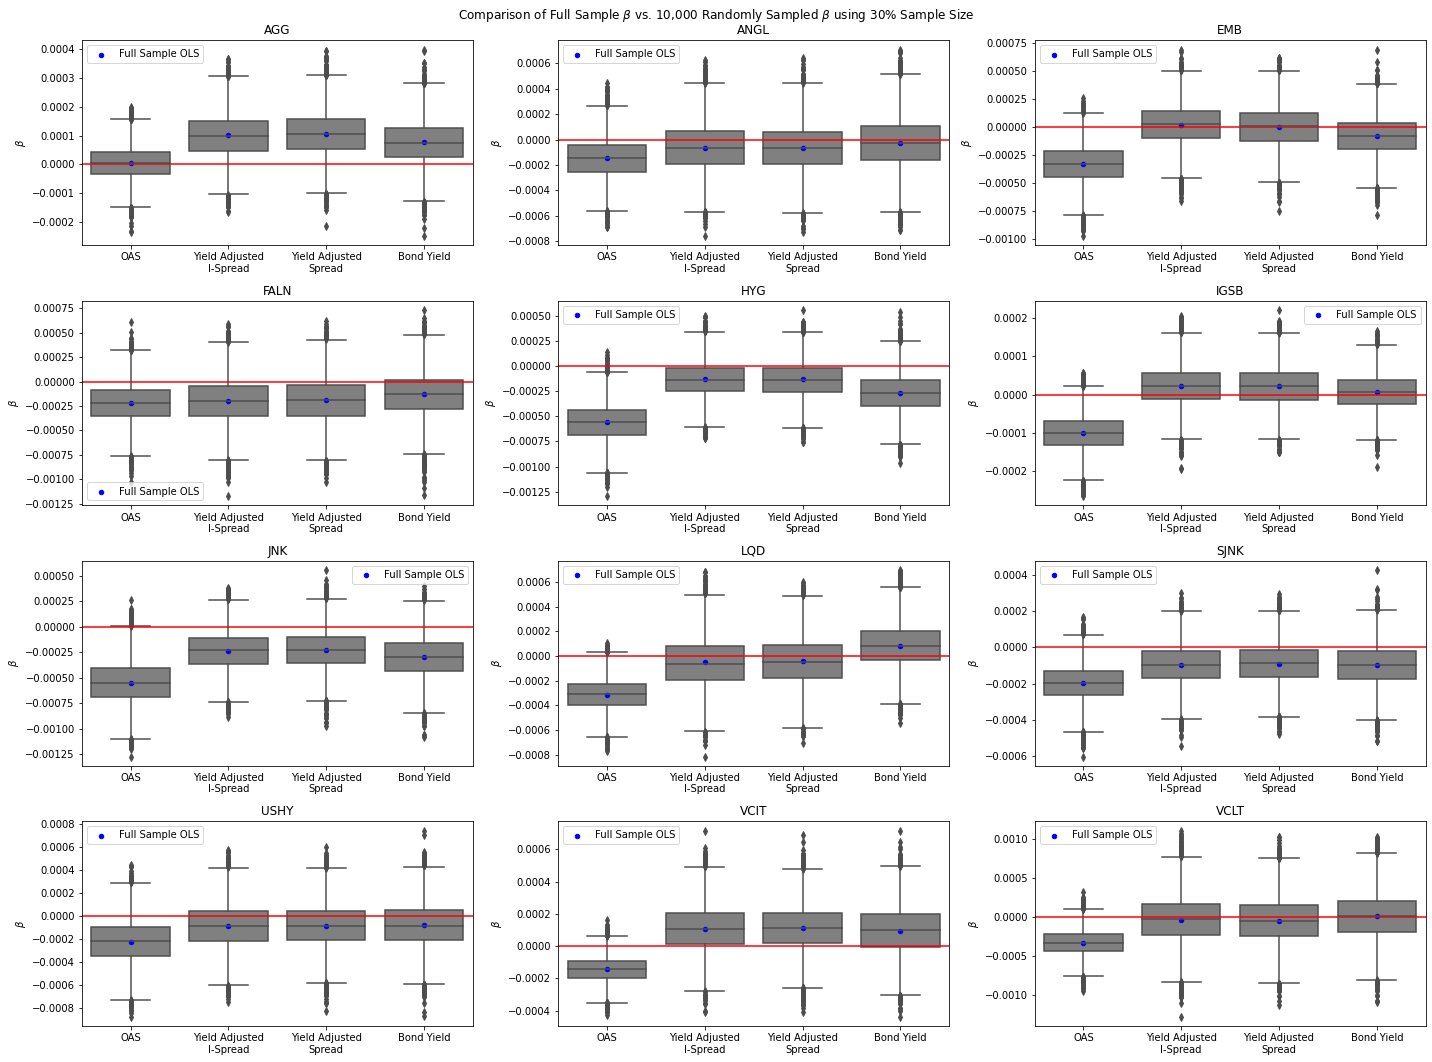

In [3]:
def plot_bootstrapped_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_sample      = SignalOLS().bootstrapped_sample_ols()
    df_full_sample = (df[
        ["security", "variable", "param_val"]].
        drop_duplicates())

    renamer = {
        "wac"        : "Weighted Avg\nCoupon",
        "yas_ispread": "Yield Adjusted\nI-Spread",
        "yas_sprd"   : "Yield Adjusted\nSpread",
        "yas_yls"    : "Bond Yield"}

    variables = df_full_sample.security.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 4, nrows = len(variables) // 3, figsize = (20,15))

    for variable, ax in zip(variables, axes.flatten()):

        df_sampled = (df_sample.query(
            "security == @variable").
            replace(renamer))

        df_full = (df_full_sample.query(
            "security == @variable").
            replace(renamer))

        sns.boxplot(
            data  = df_sampled,
            x     = "variable",
            y     = "param_val",
            ax    = ax,
            color = "grey")

        ax.axhline(y = 0, color = "red")

        (df_full.plot(
            ax    = ax,
            kind  = "scatter", 
            x     = "variable",
            y     = "param_val",
            color = "blue",
            label = "Full Sample OLS",
            title = variable))

        ax.set_ylabel(r"$\beta$")
        ax.set_xlabel("")

    fig.suptitle(
        r"Comparison of Full Sample $\beta$ vs. 10,000 Randomly Sampled $\beta$ using 30% Sample Size")
    plt.tight_layout()
    
plot_bootstrapped_ols(df)

## Expanding OOS

In [4]:
def expanding_security_sharpe() -> pd.DataFrame: 
    
    df_sharpe = (SignalOLS().expanding_ols()[
        ["security", "variable", "signal_rtn"]].
        groupby(["security", "variable"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_expanding_sharpe = expanding_security_sharpe()

In [5]:
def get_security_sharpe(df: pd.DataFrame) -> pd.DataFrame:
    
    df_sharpe = (df[
        ["security", "variable", "signal_rtn"]].
        groupby(["security", "variable"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_security_sharpe = get_security_sharpe(df)

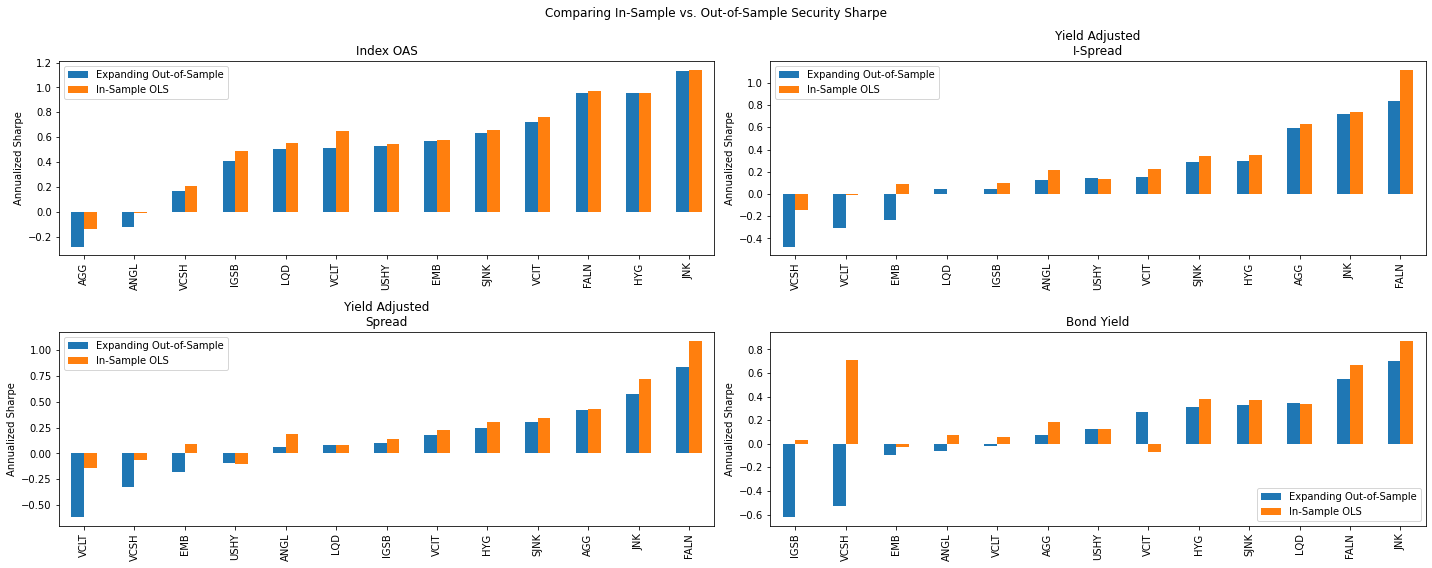

In [6]:
def plot_inout_security_sharpe(df_expanding_sharpe: pd.DataFrame, df_security_sharpe: pd.DataFrame) -> plt.Figure:
    
    df_tmp = (df_expanding_sharpe.drop(
        columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"sharpe": "expanding"}).
        merge(right = df_security_sharpe, how = "inner", on = ["security", "variable"]).
        drop(columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"sharpe": "in_sample"}))

    renamer = {
        "OAS"        : "Index OAS",
        "yas_ispread": "Yield Adjusted\nI-Spread",
        "yas_sprd"   : "Yield Adjusted\nSpread",
        "yas_yls"    : "Bond Yield"}

    col_renamer =  {
        "expanding": "Expanding Out-of-Sample",
        "in_sample": "In-Sample OLS"}

    variables = df_tmp.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (20,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_tmp.query(
            "variable == @variable").
            set_index("security").
            drop(columns = ["variable"]).
            sort_values("expanding").
            rename(columns = col_renamer).
            plot(
                kind   = "bar",
                ax     = ax,
                ylabel = "Annualized Sharpe",
                title  = renamer[variable],
                xlabel = ""))

    fig.suptitle("Comparing In-Sample vs. Out-of-Sample Security Sharpe")
    plt.tight_layout()
    
plot_inout_security_sharpe(df_expanding_sharpe, df_security_sharpe)

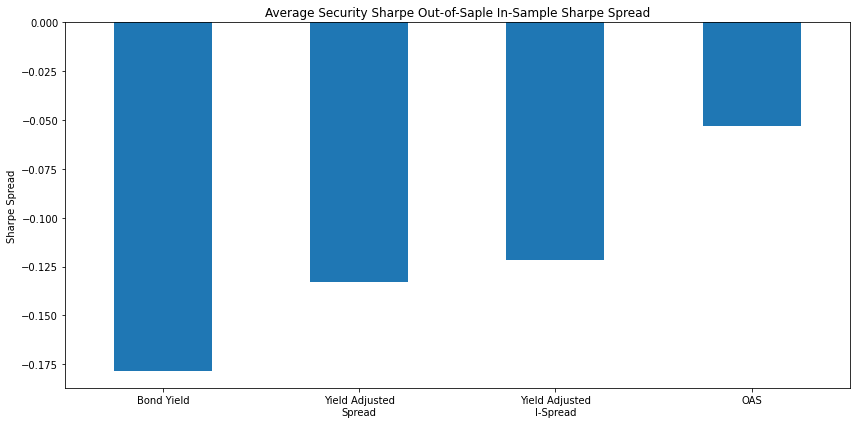

In [7]:
def plot_avg_sharpe_spread(df_expanding_sharpe: pd.DataFrame, df_security_sharpe: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "wac"        : "Weighted Avg\nCoupon",
        "yas_ispread": "Yield Adjusted\nI-Spread",
        "yas_sprd"   : "Yield Adjusted\nSpread",
        "yas_yls"    : "Bond Yield"}

    (df_expanding_sharpe.drop(
        columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"sharpe": "expanding_sharpe"}).
        merge(right = df_security_sharpe, how = "inner", on = ["security", "variable"]).
        drop(columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"sharpe": "in_sample"}).
        assign(sharpe_spread = lambda x: x.expanding_sharpe -  x.in_sample)
        [["variable", "sharpe_spread"]].
        replace(renamer).
        groupby("variable").
        agg("mean").
        sort_values("sharpe_spread").
        plot(
            kind    = "bar",
            legend  = False,
            figsize = (12,6),
            ylabel  = "Sharpe Spread",
            rot     = 0,
            xlabel  = "",
            title   = "Average Security Sharpe Out-of-Saple In-Sample Sharpe Spread"))
    
    plt.tight_layout()
    
plot_avg_sharpe_spread(df_expanding_sharpe, df_security_sharpe)

In [8]:
def get_avg_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df[
        ["date", "variable", "signal_rtn"]].
        groupby(["date", "variable"]).
        agg("mean").
        reset_index())
    
    return df_out

df_avg_rtn = get_avg_rtn(df)

In [9]:
def get_avg_sharpe(df_avg_rtn: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df_avg_rtn.drop(
        columns = ["date"]).
        groupby("variable").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_out

df_sharpe = get_avg_sharpe(df_avg_rtn)

In [10]:
def get_inout_sharpe(df_sharpe: pd.DataFrame) -> pd.DataFrame: 
    
    df_exp = (SignalOLS().expanding_ols()[
        ["date", "variable", "signal_rtn"]].
        groupby(["date", "variable"]).
        agg("mean").
        reset_index().
        drop(columns = ["date"]).
        groupby(["variable"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(exp_sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["exp_sharpe"]])

    df_out = (df_sharpe.rename(
        columns = {"sharpe": "in_sharpe"})
        [["in_sharpe"]].
        merge(right = df_exp, how = "inner", on = ["variable"]))
    
    return df_out

df_inout_sharpe = get_inout_sharpe(df_sharpe)

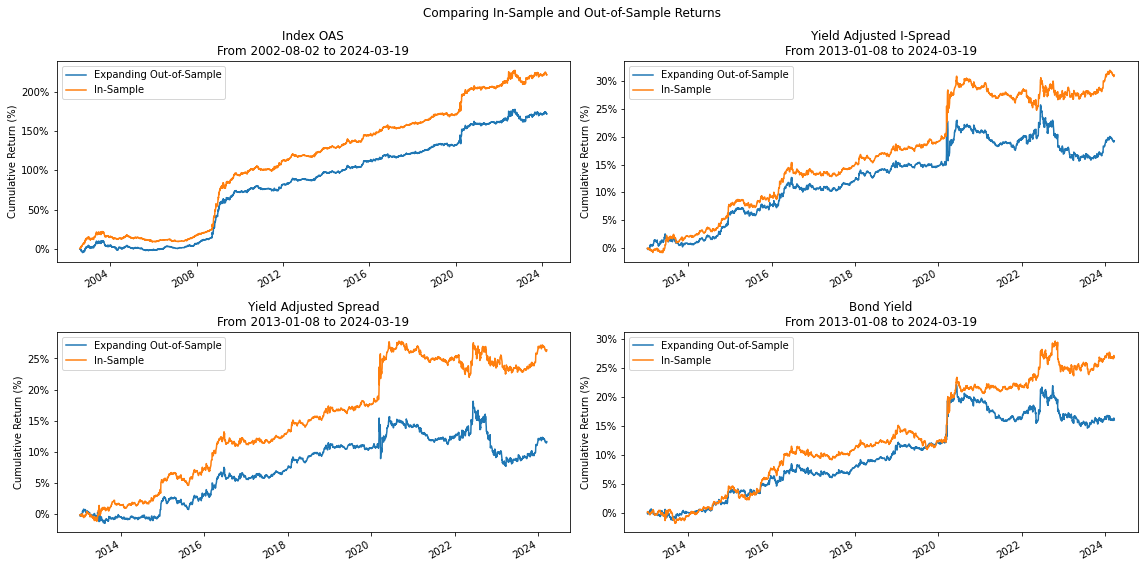

In [11]:
def plot_returns_comparison(df_avg_rtn: pd.DataFrame) -> plt.Figure:
    
    df_combined = (SignalOLS().expanding_ols()[
        ["date", "variable", "signal_rtn"]].
        groupby(["date", "variable"]).
        agg("mean").
        reset_index().
        rename(columns = {"signal_rtn": "expanding"}).
        merge(right = df_avg_rtn, how = "inner", on = ["date", "variable"]).
        dropna())

    renamer = {
        "OAS"        : "Index OAS",
        "yas_ispread": "Yield Adjusted I-Spread",
        "yas_sprd"   : "Yield Adjusted Spread",
        "yas_yls"    : "Bond Yield"}

    col_renamer = {
        "expanding" : "Expanding Out-of-Sample",
        "signal_rtn": "In-Sample"}

    variables = df_combined.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (16,8))

    for variable, ax in zip(variables, axes.flatten()):

        df_plot = (df_combined.query(
            "variable == @variable").
            set_index("date").
            drop(columns = ["variable"]).
            apply(lambda x: np.cumprod(1 + x) - 1).
            rename(columns = col_renamer))
        
        (df_plot.plot(
            ax     = ax,
            xlabel = "",
            ylabel = "Cumulative Return (%)",
            title  = renamer[variable] + "\nFrom {} to {}".format(
                df_plot.index.min().date(),
                df_plot.index.max().date())))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle("Comparing In-Sample and Out-of-Sample Returns")
    plt.tight_layout()
    
plot_returns_comparison(df_avg_rtn)

In [12]:
def get_avg_port_sharpe(df_avg_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_combined = (SignalOLS().expanding_ols()[
        ["date", "variable", "signal_rtn"]].
        groupby(["date", "variable"]).
        agg("mean").
        reset_index().
        rename(columns = {"signal_rtn": "expanding"}).
        merge(right = df_avg_rtn, how = "inner", on = ["date", "variable"]).
        dropna())

    df_sharpe = (df_combined.rename(
        columns = {"variable": "ir_var"}).
        melt(id_vars = ["date", "ir_var"]).
        drop(columns = ["date"]).
        groupby(["ir_var", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_port_sharpe = get_avg_port_sharpe(df_avg_rtn)

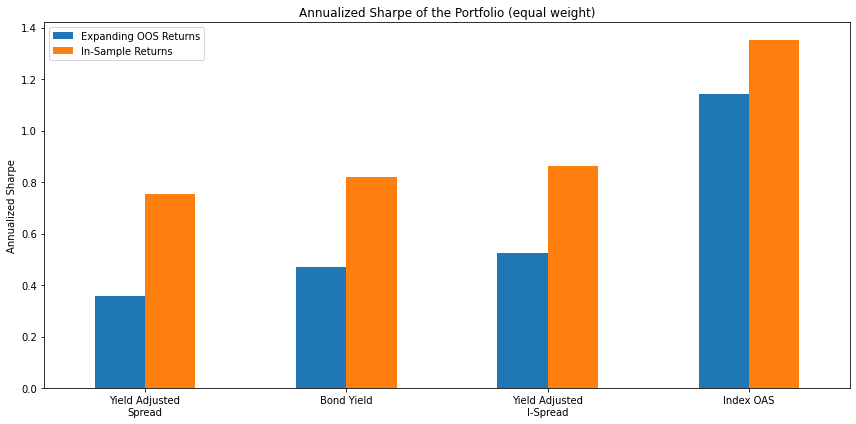

In [13]:
def plot_port_sharpe(df_port_sharpe: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "OAS"        : "Index OAS",
        "yas_ispread": "Yield Adjusted\nI-Spread",
        "yas_sprd"   : "Yield Adjusted\nSpread",
        "yas_yls"    : "Bond Yield"}

    (df_port_sharpe.rename(
        columns = {"variable": ""}).
        replace(renamer).
        pivot(index = "ir_var", columns = "", values = "sharpe").
        sort_values("signal_rtn").
        rename(columns = {
            "signal_rtn": "In-Sample Returns",
            "expanding" : "Expanding OOS Returns"}).
        plot(
            kind    = "bar",
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            figsize = (12,6),
            rot     = 0,
            title   = "Annualized Sharpe of the Portfolio (equal weight)"))

    plt.tight_layout()
    
plot_port_sharpe(df_port_sharpe)

## Combining all Signals

In [14]:
def combine_port(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_exp = (SignalOLS().expanding_ols()[
        ["date", "signal_rtn"]].
        groupby("date").
        agg("mean").
        rename(columns = {"signal_rtn": "exp_rtn"}))

    df_in = (df[
        ["date", "signal_rtn"]].
        groupby("date").
        agg("mean").
        rename(columns = {"signal_rtn": "in_rtn"}))

    df_out = (df_exp.merge(
        right = df_in, how = "inner", on = ["date"]))
    
    return df_out

df_port = combine_port(df)

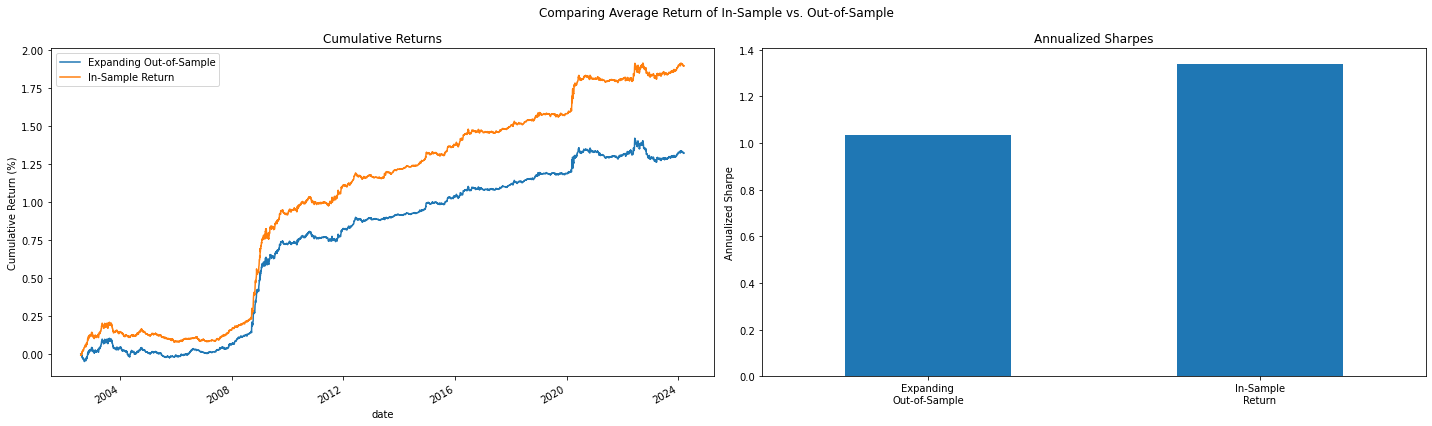

In [15]:
def plot_compare_port(df_port: pd.DataFrame) -> plt.Figure: 
    
    col_renamer = {
        "exp_rtn": "Expanding Out-of-Sample",
        "in_rtn" : "In-Sample Return"}

    replacer = {
        "exp_rtn": "Expanding\nOut-of-Sample",
        "in_rtn" : "In-Sample\nReturn"}

    df_sharpe = ((df_port.mean() / df_port.std()).to_frame(name = "sharpe").apply(lambda x: np.sqrt(252) * x).reset_index().replace(
        replacer).
        set_index("index"))

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_port.apply(
        lambda x: np.cumprod(1 + x) - 1).
        rename(columns = col_renamer).
        plot(
            ax     = axes[0],
            ylabel = "Cumulative Return (%)",
            title  = "Cumulative Returns"))

    (df_sharpe.plot(
        kind   = "bar", 
        ax     = axes[1],
        xlabel = "",
        rot    = 0,
        legend = False,
        ylabel = "Annualized Sharpe",
        title  = "Annualized Sharpes"))

    fig.suptitle("Comparing Average Return of In-Sample vs. Out-of-Sample")
    plt.tight_layout()
    
plot_compare_port(df_port)